<a href="https://colab.research.google.com/github/jeanlucjackson/w266_final_project/blob/main/code/sandboxes/RR/rr_evaluation_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
from matplotlib import pyplot as plt

import scipy.stats as st

pd.set_option("precision", 5)
sns.set_theme()

In [3]:
evaluation_root = "/content/drive/MyDrive/w266 NLP Final Project/Evaluation/"
filename = evaluation_root + "evaluation_database.json"

evaluation_df = pd.read_json(filename)

In [4]:
evaluation_df.columns

Index(['prediction_set', 'base_model', 'trained_on', 'tested_on', 'nickname',
       'target', 'prediction', 'bleu', 'rouge1', 'rouge2', 'rougeL',
       'rougeLsum', 'meteor', 'bertscore-precision', 'bertscore-recall',
       'bertscore-f1', 'bleurt'],
      dtype='object')

In [92]:
evaluation_metrics = evaluation_df.select_dtypes(exclude="object").columns
evaluation_metrics

Index(['bleu', 'rougeL', 'meteor', 'bleurt', 'bertscore-f1'], dtype='object')

In [93]:
training_sets = evaluation_df['trained_on'].unique()
training_sets

array(['nq', 'triviaqa', 'squad', 'quac', 'amalgam'], dtype=object)

### BART vs T5



We built 5 BART models and 5 T5 models.

Each set of 5 models includes one model trained on each of our datasets plus one trained on all of our datasets.

We ran the validation sets from each of our datasets on each of our ten models yielding 40 sets of predictions.

#### In The Aggregate

We group the prediction sets by base model and calculate the mean for each metric.

In every case, the BART models outperform the T5 models.

We applied Welch's t-test to the metric distributions between the two models and, in each case, found $p$ values of less than .05 and reject the hypothesis that the distributions have equal means.

In [36]:
evaluation_df.groupby(["base_model"]).mean()

,bleu,rougeL,meteor,bleurt,bertscore-f1
base_model,,,,,
T5,0.0387,0.27841,0.25954,-0.92718,0.78287
bart,0.0518,0.31417,0.29325,-0.79155,0.79770


In [7]:
df_T5 = evaluation_df[evaluation_df['base_model'] == 'T5']
df_BART = evaluation_df[evaluation_df['base_model'] == 'bart']

In [110]:
for metric in evaluation_metrics:
  p = st.ttest_ind(df_T5[metric], df_BART[metric], equal_var=False)[1]
  reject_null = "FAILURE to reject the null"
  if p <= .05:
    reject_null = "reject the null"
  print(f"metric: {metric} Welch's t-test p value {p}, {reject_null}")

metric: bleu Welch's t-test p value 3.764658780054812e-119, reject the null
metric: rougeL Welch's t-test p value 0.0, reject the null
metric: meteor Welch's t-test p value 0.0, reject the null
metric: bleurt Welch's t-test p value 0.0, reject the null
metric: bertscore-f1 Welch's t-test p value 0.0, reject the null


#### Per Training Set

We group the prediction sets by base model and training set and calculate the mean for each metric.

In every case, the BART models outperform the T5 models.

We applied Welch's t-test to the metric distributions between the two models on each training set and metric, and, in each case, found $p$ values of less than .05 and reject the hypothesis that the distributions have equal means.


In [46]:
df = evaluation_df.groupby(["trained_on", "base_model", ]).mean()
df = df.reset_index()
df

,trained_on,base_model,bleu,rougeL,meteor,bleurt,bertscore-f1
0,amalgam,T5,0.08563,0.38169,0.37254,-0.57658,0.83105
1,amalgam,bart,0.09873,0.38872,0.38606,-0.56501,0.83154
2,nq,T5,0.02117,0.28921,0.22292,-0.95578,0.76594
3,nq,bart,0.02499,0.29348,0.22864,-0.92741,0.76848
4,quac,T5,0.00097,0.15093,0.12027,-1.42809,0.72844
5,quac,bart,0.02474,0.26015,0.22003,-0.95596,0.78025
6,squad,T5,0.05884,0.32965,0.31757,-0.72394,0.81023
7,squad,bart,0.06580,0.33418,0.32219,-0.71181,0.81203
8,triviaqa,T5,0.02687,0.24057,0.26442,-0.95152,0.77868
9,triviaqa,bart,0.04471,0.29434,0.30931,-0.79754,0.79623


In [100]:
for training_set in training_sets:
  for metric in evaluation_metrics:
    print(f"training set: {training_set} metric: {metric}", end=" ")
    T5 = df[(df["base_model"] == "T5") & (df["trained_on"] == training_set)][metric].values[0]
    BART = df[(df["base_model"] == "bart") & (df["trained_on"] == training_set)][metric].values[0]
    if BART > T5:
      print ("BART outperforms T5")
    else:
      print ("T5 outperforms BART")

training set: nq metric: bleu BART outperforms T5
training set: nq metric: rougeL BART outperforms T5
training set: nq metric: meteor BART outperforms T5
training set: nq metric: bleurt BART outperforms T5
training set: nq metric: bertscore-f1 BART outperforms T5
training set: triviaqa metric: bleu BART outperforms T5
training set: triviaqa metric: rougeL BART outperforms T5
training set: triviaqa metric: meteor BART outperforms T5
training set: triviaqa metric: bleurt BART outperforms T5
training set: triviaqa metric: bertscore-f1 BART outperforms T5
training set: squad metric: bleu BART outperforms T5
training set: squad metric: rougeL BART outperforms T5
training set: squad metric: meteor BART outperforms T5
training set: squad metric: bleurt BART outperforms T5
training set: squad metric: bertscore-f1 BART outperforms T5
training set: quac metric: bleu BART outperforms T5
training set: quac metric: rougeL BART outperforms T5
training set: quac metric: meteor BART outperforms T5
tra

In [112]:
for training_set in training_sets:
  T5_set = df_T5[df_T5['trained_on'] == training_set]
  BART_set = df_BART[df_BART['trained_on'] == training_set]

  for metric in evaluation_metrics:
    p = st.ttest_ind(T5_set[metric], BART_set[metric], equal_var=False)[1]
    reject_null = "FAILURE to reject the null"
    if p <= .05:
      reject_null = "reject the null"

    print(f"training set: {training_set} metric: {metric} p value: {p}, {reject_null}")

training set: nq metric: bleu p value: 1.992906597378803e-05, reject the null
training set: nq metric: rougeL p value: 0.014497692035772832, reject the null
training set: nq metric: meteor p value: 0.0007313322173923156, reject the null
training set: nq metric: bleurt p value: 2.978969780151862e-10, reject the null
training set: nq metric: bertscore-f1 p value: 3.1853590325324764e-05, reject the null
training set: triviaqa metric: bleu p value: 3.097044394772555e-71, reject the null
training set: triviaqa metric: rougeL p value: 2.8278862414229315e-229, reject the null
training set: triviaqa metric: meteor p value: 1.4343362459542718e-149, reject the null
training set: triviaqa metric: bleurt p value: 8.675016634369094e-267, reject the null
training set: triviaqa metric: bertscore-f1 p value: 8.02469807243913e-172, reject the null
training set: squad metric: bleu p value: 2.670640503512896e-06, reject the null
training set: squad metric: rougeL p value: 0.021409787787484254, reject the

### Kendall's Tau

In [9]:
evaluation_df = evaluation_df[['base_model', 'trained_on', 'tested_on', 'bleu', 'rougeL', 'meteor', 'bleurt', 'bertscore-f1']]

In [10]:
baseline = (
    evaluation_df[
        (evaluation_df["base_model"] == "T5")
        & (evaluation_df["trained_on"] == "squad")
        & (evaluation_df["tested_on"] == "squad")
    ]
    .groupby(["base_model", "trained_on", "tested_on"])
    .mean()
)
baseline

,,,bleu,rougeL,meteor,bleurt,bertscore-f1
base_model,trained_on,tested_on,,,,,
T5,squad,squad,0.13233,0.45207,0.4555,-0.31867,0.86493


In [11]:
nq_df = (
    evaluation_df[evaluation_df["tested_on"] == "nq"]
    .groupby(["base_model", "trained_on", "tested_on"])
    .mean()
    .sort_values(by=["bertscore-f1"], ascending=False)
)

nq_df

bleu   rougeL   meteor   bleurt  \
base_model trained_on tested_on                                       
bart       nq         nq         0.20307  0.55043  0.52880 -0.25072   
           amalgam    nq         0.19669  0.54500  0.52354 -0.26720   
T5         nq         nq         0.16104  0.51909  0.49161 -0.36865   
           amalgam    nq         0.16134  0.52017  0.49404 -0.35621   
bart       squad      nq         0.01179  0.41060  0.35530 -0.63291   
T5         squad      nq         0.01195  0.40648  0.35192 -0.66086   
bart       triviaqa   nq         0.01142  0.36562  0.36744 -0.73634   
T5         triviaqa   nq         0.00580  0.27229  0.29164 -0.94372   
bart       quac       nq         0.00504  0.32612  0.22437 -0.99088   
T5         quac       nq         0.00015  0.14482  0.07611 -1.50722   

                                 bertscore-f1  
base_model trained_on tested_on                
bart       nq         nq              0.86740  
           amalgam    nq              0.86433  
T5         nq         nq              0.85663  
           amalgam    nq              0.85637  
bart       squad      nq              0.79860  
T5         squad      nq              0.79641  
bart       triviaqa   nq              0.79559  
T5         triviaqa   nq              0.77015  
bart       quac       nq              0.75054  
T5         quac       nq              0.68803

In [12]:
quac_df = (
    evaluation_df[evaluation_df["tested_on"] == "quac"]
    .groupby(["base_model", "trained_on", "tested_on"])
    .mean()
    .sort_values(by=["bertscore-f1"], ascending=False)
)

quac_df

bleu   rougeL   meteor   bleurt  \
base_model trained_on tested_on                                       
bart       quac       quac       0.05722  0.28275  0.28805 -0.80825   
T5         amalgam    quac       0.02904  0.25220  0.25508 -0.93554   
bart       amalgam    quac       0.02741  0.23367  0.25015 -1.04438   
T5         quac       quac       0.00260  0.17103  0.16533 -1.37046   
           squad      quac       0.00619  0.18373  0.20958 -1.15841   
bart       squad      quac       0.00712  0.18418  0.20587 -1.21476   
           triviaqa   quac       0.00146  0.11367  0.16401 -1.37454   
T5         triviaqa   quac       0.00097  0.09891  0.14970 -1.38607   
bart       nq         quac       0.00108  0.14961  0.11261 -1.34135   
T5         nq         quac       0.00100  0.15030  0.11132 -1.36087   

                                 bertscore-f1  
base_model trained_on tested_on                
bart       quac       quac            0.79280  
T5         amalgam    quac            0.78506  
bart       amalgam    quac            0.77052  
T5         quac       quac            0.76010  
           squad      quac            0.75426  
bart       squad      quac            0.75398  
           triviaqa   quac            0.70975  
T5         triviaqa   quac            0.70734  
bart       nq         quac            0.69718  
T5         nq         quac            0.69640

In [13]:
squad_df = (
    evaluation_df[evaluation_df["tested_on"] == "squad"]
    .groupby(["base_model", "trained_on", "tested_on"])
    .mean()
    .sort_values(by=["bertscore-f1"], ascending=False)
)

squad_df

bleu   rougeL   meteor   bleurt  \
base_model trained_on tested_on                                       
bart       squad      squad      0.15124  0.46919  0.47534 -0.26694   
T5         squad      squad      0.13233  0.45207  0.45550 -0.31867   
bart       amalgam    squad      0.13581  0.45858  0.46014 -0.30807   
T5         amalgam    squad      0.12522  0.45517  0.45304 -0.32648   
bart       triviaqa   squad      0.04703  0.31041  0.33821 -0.64540   
           quac       squad      0.02772  0.29090  0.24561 -0.83182   
T5         triviaqa   squad      0.02849  0.24260  0.28936 -0.87923   
           nq         squad      0.01408  0.33007  0.25932 -0.76260   
bart       nq         squad      0.01439  0.32262  0.25203 -0.76472   
T5         quac       squad      0.00094  0.17344  0.13432 -1.35503   

                                 bertscore-f1  
base_model trained_on tested_on                
bart       squad      squad           0.86954  
T5         squad      squad           0.86493  
bart       amalgam    squad           0.86285  
T5         amalgam    squad           0.86205  
bart       triviaqa   squad           0.81675  
           quac       squad           0.80295  
T5         triviaqa   squad           0.79096  
           nq         squad           0.78627  
bart       nq         squad           0.78382  
T5         quac       squad           0.74166

In [14]:
triviaqa_df = (
    evaluation_df[evaluation_df["tested_on"] == "triviaqa"]
    .groupby(["base_model", "trained_on", "tested_on"])
    .mean()
    .sort_values(by=["bertscore-f1"], ascending=False)
)

triviaqa_df

bleu   rougeL   meteor   bleurt  \
base_model trained_on tested_on                                       
bart       amalgam    triviaqa   0.07797  0.36872  0.35459 -0.62649   
           triviaqa   triviaqa   0.07601  0.36778  0.35103 -0.63144   
T5         amalgam    triviaqa   0.05869  0.34681  0.32700 -0.68398   
           triviaqa   triviaqa   0.04561  0.31530  0.29953 -0.77181   
           squad      triviaqa   0.02251  0.26675  0.22553 -0.91539   
bart       squad      triviaqa   0.02193  0.26027  0.21907 -0.90873   
           nq         triviaqa   0.00800  0.28644  0.20083 -1.01739   
T5         nq         triviaqa   0.00732  0.27312  0.18601 -1.06236   
bart       quac       triviaqa   0.00687  0.19781  0.15091 -1.16915   
T5         quac       triviaqa   0.00024  0.11620  0.08886 -1.52205   

                                 bertscore-f1  
base_model trained_on tested_on                
bart       amalgam    triviaqa        0.82643  
           triviaqa   triviaqa        0.82592  
T5         amalgam    triviaqa        0.81911  
           triviaqa   triviaqa        0.81009  
           squad      triviaqa        0.78815  
bart       squad      triviaqa        0.78809  
           nq         triviaqa        0.77083  
T5         nq         triviaqa        0.76386  
bart       quac       triviaqa        0.75547  
T5         quac       triviaqa        0.70503

In [15]:
metrics = list(squad_df.columns)
datasets = evaluation_df["tested_on"].unique()
print(f"metrics = {metrics} \ndatasets = {datasets}")

metrics = ['bleu', 'rougeL', 'meteor', 'bleurt', 'bertscore-f1'] 
datasets = ['nq' 'squad' 'quac' 'triviaqa']


In [16]:
# We gather the predictions for a validation dataset
# Sort the rows from best to worst scores on one metric
# Then we build ranking vectors for all metrics

rankings = {}

for dataset in datasets:
    df = (
        evaluation_df[evaluation_df["tested_on"] == dataset]
        .groupby(["base_model", "trained_on", "tested_on"])
        .mean()
        .sort_values(by=["bleu"], ascending=False)
    )
    for metric in metrics:
        vector = [sorted(df[metric], reverse=True).index(x) + 1 for x in df[metric]]
        rankings[(dataset, metric)] = vector

In [17]:
rankings

{('nq', 'bleu'): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 ('nq', 'rougeL'): [1, 2, 3, 4, 6, 5, 7, 9, 8, 10],
 ('nq', 'meteor'): [1, 2, 3, 4, 7, 6, 5, 8, 9, 10],
 ('nq', 'bleurt'): [1, 2, 3, 4, 6, 5, 7, 8, 9, 10],
 ('nq', 'bertscore-f1'): [1, 2, 4, 3, 6, 5, 7, 8, 9, 10],
 ('squad', 'bleu'): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 ('squad', 'rougeL'): [1, 2, 4, 3, 7, 9, 8, 6, 5, 10],
 ('squad', 'meteor'): [1, 2, 3, 4, 5, 6, 9, 8, 7, 10],
 ('squad', 'bleurt'): [1, 2, 3, 4, 5, 9, 8, 7, 6, 10],
 ('squad', 'bertscore-f1'): [1, 3, 2, 4, 5, 7, 6, 9, 8, 10],
 ('quac', 'bleu'): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 ('quac', 'rougeL'): [1, 2, 3, 4, 5, 6, 9, 8, 7, 10],
 ('quac', 'meteor'): [1, 2, 3, 5, 4, 6, 7, 9, 10, 8],
 ('quac', 'bleurt'): [1, 2, 3, 5, 4, 8, 9, 6, 7, 10],
 ('quac', 'bertscore-f1'): [1, 2, 3, 6, 5, 4, 7, 9, 10, 8],
 ('triviaqa', 'bleu'): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 ('triviaqa', 'rougeL'): [1, 2, 3, 4, 7, 8, 5, 6, 9, 10],
 ('triviaqa', 'meteor'): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 ('triviaqa

In [18]:
vectors = {}
for dataset in datasets:
    vectors[dataset] = {metric: rankings[(dataset, metric)] for metric in metrics}
vectors

{'nq': {'bleu': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  'rougeL': [1, 2, 3, 4, 6, 5, 7, 9, 8, 10],
  'meteor': [1, 2, 3, 4, 7, 6, 5, 8, 9, 10],
  'bleurt': [1, 2, 3, 4, 6, 5, 7, 8, 9, 10],
  'bertscore-f1': [1, 2, 4, 3, 6, 5, 7, 8, 9, 10]},
 'squad': {'bleu': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  'rougeL': [1, 2, 4, 3, 7, 9, 8, 6, 5, 10],
  'meteor': [1, 2, 3, 4, 5, 6, 9, 8, 7, 10],
  'bleurt': [1, 2, 3, 4, 5, 9, 8, 7, 6, 10],
  'bertscore-f1': [1, 3, 2, 4, 5, 7, 6, 9, 8, 10]},
 'quac': {'bleu': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  'rougeL': [1, 2, 3, 4, 5, 6, 9, 8, 7, 10],
  'meteor': [1, 2, 3, 5, 4, 6, 7, 9, 10, 8],
  'bleurt': [1, 2, 3, 5, 4, 8, 9, 6, 7, 10],
  'bertscore-f1': [1, 2, 3, 6, 5, 4, 7, 9, 10, 8]},
 'triviaqa': {'bleu': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  'rougeL': [1, 2, 3, 4, 7, 8, 5, 6, 9, 10],
  'meteor': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  'bleurt': [1, 2, 3, 4, 6, 5, 7, 8, 9, 10],
  'bertscore-f1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}}

In [19]:
ranking_df = {dataset: pd.DataFrame(vectors[dataset]) for dataset in datasets}
for k, v in ranking_df.items():
  print(k)
  print(v)

nq
   bleu  rougeL  meteor  bleurt  bertscore-f1
0     1       1       1       1             1
1     2       2       2       2             2
2     3       3       3       3             4
3     4       4       4       4             3
4     5       6       7       6             6
5     6       5       6       5             5
6     7       7       5       7             7
7     8       9       8       8             8
8     9       8       9       9             9
9    10      10      10      10            10
squad
   bleu  rougeL  meteor  bleurt  bertscore-f1
0     1       1       1       1             1
1     2       2       2       2             3
2     3       4       3       3             2
3     4       3       4       4             4
4     5       7       5       5             5
5     6       9       6       9             7
6     7       8       9       8             6
7     8       6       8       7             9
8     9       5       7       6             8
9    10      10      10  

In [20]:
kendall_df = {dataset: ranking_df[dataset].corr(method='kendall') for dataset in datasets}
for k, v in kendall_df.items():
  print(k)
  print(v)

nq
                 bleu   rougeL   meteor   bleurt  bertscore-f1
bleu          1.00000  0.91111  0.86667  0.95556       0.91111
rougeL        0.91111  1.00000  0.86667  0.95556       0.91111
meteor        0.86667  0.86667  1.00000  0.91111       0.86667
bleurt        0.95556  0.95556  0.91111  1.00000       0.95556
bertscore-f1  0.91111  0.91111  0.86667  0.95556       1.00000
squad
                 bleu   rougeL   meteor   bleurt  bertscore-f1
bleu          1.00000  0.60000  0.86667  0.73333       0.86667
rougeL        0.60000  1.00000  0.73333  0.86667       0.64444
meteor        0.86667  0.73333  1.00000  0.86667       0.82222
bleurt        0.73333  0.86667  0.86667  1.00000       0.77778
bertscore-f1  0.86667  0.64444  0.82222  0.77778       1.00000
quac
                 bleu   rougeL   meteor   bleurt  bertscore-f1
bleu          1.00000  0.86667  0.86667  0.77778       0.77778
rougeL        0.86667  1.00000  0.73333  0.82222       0.64444
meteor        0.86667  0.73333  1.00000  

In [21]:
# It does not matter which set we use to build the mask
mask = np.triu(np.ones_like(kendall_df["squad"].corr(), dtype=bool))
mask

array([[ True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True],
       [False, False,  True,  True,  True],
       [False, False, False,  True,  True],
       [False, False, False, False,  True]])

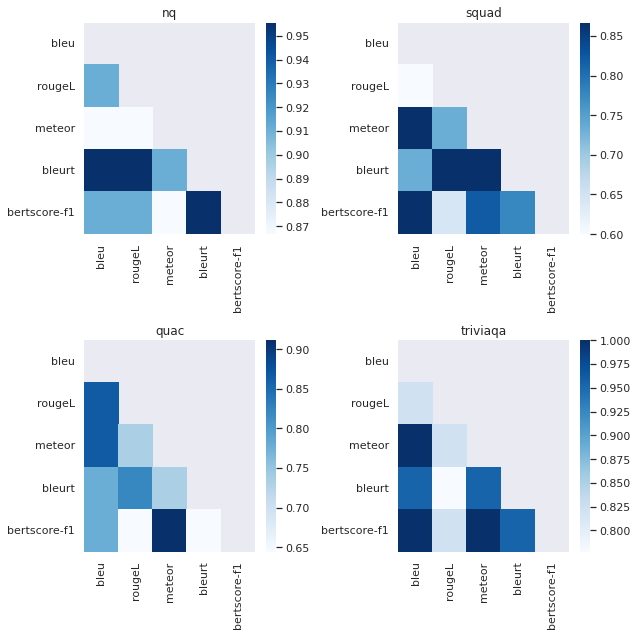

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(9,9))

for ax, dataset in zip (axes.flat, datasets):
  sns.heatmap(kendall_df[dataset], mask=mask, cmap="Blues", ax=ax).set(title=dataset)

fig.tight_layout()

plt.show()

### Cosine Similarity

In [23]:
vectors = {}
for dataset in datasets:
    vectors[dataset] = [rankings[(dataset, metric)] for metric in metrics]

In [24]:
similarity = {}
for dataset in datasets:
    similarity[dataset] = pd.DataFrame(
        cosine_similarity(vectors[dataset]), columns=metrics, index=metrics
    )

In [25]:
similarity["nq"]

,bleu,rougeL,meteor,bleurt,bertscore-f1
bleu,1.00000,0.99481,0.98961,0.99740,0.99481
rougeL,0.99481,1.00000,0.98961,0.99740,0.99481
meteor,0.98961,0.98961,1.00000,0.99221,0.98961
bleurt,0.99740,0.99740,0.99221,1.00000,0.99740
bertscore-f1,0.99481,0.99481,0.98961,0.99740,1.00000


In [26]:
similarity["quac"]

,bleu,rougeL,meteor,bleurt,bertscore-f1
bleu,1.00000,0.98961,0.98961,0.97662,0.98182
rougeL,0.98961,1.00000,0.97403,0.98701,0.96623
meteor,0.98961,0.97403,1.00000,0.96104,0.99221
bleurt,0.97662,0.98701,0.96104,1.00000,0.94286
bertscore-f1,0.98182,0.96623,0.99221,0.94286,1.00000


In [27]:
similarity["squad"]

,bleu,rougeL,meteor,bleurt,bertscore-f1
bleu,1.00000,0.95325,0.98961,0.97403,0.99221
rougeL,0.95325,1.00000,0.96883,0.98961,0.95325
meteor,0.98961,0.96883,1.00000,0.98442,0.98182
bleurt,0.97403,0.98961,0.98442,1.00000,0.97662
bertscore-f1,0.99221,0.95325,0.98182,0.97662,1.00000


In [28]:
similarity["triviaqa"]

,bleu,rougeL,meteor,bleurt,bertscore-f1
bleu,1.00000,0.97922,1.00000,0.99740,1.00000
rougeL,0.97922,1.00000,0.97922,0.97662,0.97922
meteor,1.00000,0.97922,1.00000,0.99740,1.00000
bleurt,0.99740,0.97662,0.99740,1.00000,0.99740
bertscore-f1,1.00000,0.97922,1.00000,0.99740,1.00000


In [29]:
# It does not matter which set we use to build the mask
mask = np.triu(np.ones_like(similarity["squad"].corr(), dtype=bool))

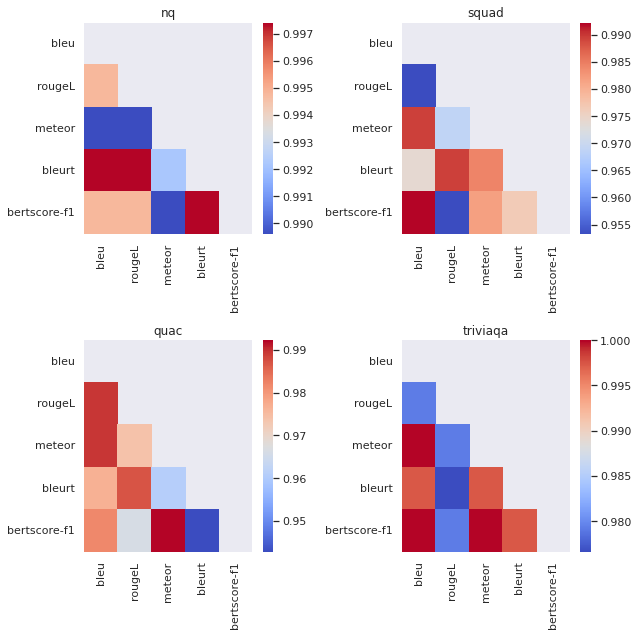

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(9,9))

for ax, dataset in zip (axes.flat, datasets):
  sns.heatmap(similarity[dataset], mask=mask, cmap="coolwarm", ax=ax).set(title=dataset)

fig.tight_layout()

plt.show()

### Black

In [31]:
!pip install black[jupyter]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 8.9 MB/s 
     |████████████████████████████████| 96 kB 6.1 MB/s 
     |████████████████████████████████| 843 kB 52.9 MB/s 
     |████████████████████████████████| 1.6 MB 23.1 MB/s 
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [32]:
!black "/content/drive/MyDrive/Colab Notebooks/rr_evaluation_sandbox.ipynb"

Usage: black [OPTIONS] SRC ...
Try 'black -h' for help.

Error: Invalid value for 'SRC ...': Path '/content/drive/MyDrive/Colab Notebooks/rr_evaluation_sandbox.ipynb' does not exist.
